In [322]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [323]:
import pandas as pd
import numpy as np
import joblib
import json

from matplotlib import pyplot as plt 
import seaborn as sns

In [324]:
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform, norm

In [325]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from helper.plots import feature_plots
from helper.utils import data_tools

In [326]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [327]:
SEED = 42

### 4. Детальное изучение признаков

Загрузим данные.

In [328]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [329]:
baseline_model = joblib.load('./model/baseline_model')

In [330]:
baseline_mae = data_tools.load_json('./model/baseline_mae.json')

`Id`

Видим, что **столбец не несет пользы**, т.к. он инкремент, поэтому нужно избавиться от него.

In [331]:
train = data_tools.Action(train, 'Id').drop_data()
#test = data_tools.Action(test, 'Id').drop_data() #Для формирования выходной таблицы Id удалим позже

Удалена фича Id


`Street`

**Столбец с сильным перекосом** в данных, поэтому нужно использовать метод с лучшим приростом к метрике.

In [332]:
train['Street'].value_counts()

Street
Pave    1454
Grvl       6
Name: count, dtype: int64

In [333]:
train, test = data_tools.Evaluate(train, test, 'Street', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,17470.57
Drop,257.86,17728.43
Fill,0.00,17470.57
Mapping,-31.71,17438.86
Bool,-27.63,17442.94


Применен мэппинг на фиче Street
Применен мэппинг на фиче Street


In [334]:
train['Street'].value_counts()

Street
0    1454
1       6
Name: count, dtype: int64

`Utilities`

**У столбца** по сути **только одно значение**, поэтому избавимся от него.

In [335]:
train['Utilities'].value_counts()

Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

In [336]:
train = data_tools.Action(train, 'Utilities').drop_data()
test = data_tools.Action(test, 'Utilities').drop_data()

Удалена фича Utilities
Удалена фича Utilities


**Оценим действия** после предобработки сложных фичей.

In [337]:
one_step_mae = data_tools.PipelineManager(train, baseline_model).get_baseline()
print(f'МАЕ Difference: {round((one_step_mae - baseline_mae['MAE']), 2)}')

МАЕ Difference: 65.2


**МАЕ немного увеличилось**, зато избавились от мусорных фичей. Рассмотрим категориальные переменные.

##### 4.1. Категориальные переменные c пропусками

Теперь рассмотрим данные по **подвалу.** 

In [338]:
bsmt = train.loc[train['BsmtQual'].isna(), ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',  'BsmtFinType2', 'TotalBsmtSF', 'SalePrice']]

display(bsmt.head(5))
print(f'Общая площадь подвала: {bsmt['TotalBsmtSF'].mean()}')

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,SalePrice
17,NaN,NaN,NaN,NaN,NaN,0,90000
39,NaN,NaN,NaN,NaN,NaN,0,82000
90,NaN,NaN,NaN,NaN,NaN,0,109900
102,NaN,NaN,NaN,NaN,NaN,0,118964
156,NaN,NaN,NaN,NaN,NaN,0,109500


Общая площадь подвала: 0.0


**Общая площадь подвала равная нулю** говорит о том, что в этих домах **отсутствует подвал** и поэтому надо пропуски заполнить меткой **No basement**.

In [339]:
bsmt_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',  'BsmtFinType2']

In [340]:
train[bsmt_columns] = train[bsmt_columns].fillna('No basement')

По такому же принципу **исследуем наличие гаража** в доме.

In [341]:
garage = train.loc[train['GarageType'].isna(), ['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType',  'GarageCars', 'GarageArea', 'SalePrice']]

display(garage.head(5))
print(f'Общая площадь гаража: {garage['GarageArea'].mean()}')

,GarageQual,GarageCond,GarageFinish,GarageType,GarageCars,GarageArea,SalePrice
39,NaN,NaN,NaN,NaN,0,0,82000
48,NaN,NaN,NaN,NaN,0,0,113000
78,NaN,NaN,NaN,NaN,0,0,136500
88,NaN,NaN,NaN,NaN,0,0,85000
89,NaN,NaN,NaN,NaN,0,0,123600


Общая площадь гаража: 0.0


По полученным данным видно, что **в доме отсутствует гараж**.

In [342]:
garage_columns = ['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']

In [343]:
train[garage_columns] = train[garage_columns].fillna('No garage')

In [344]:
two_step_mae = data_tools.PipelineManager(train, baseline_model).get_baseline()
print(f'МАЕ Difference: {round((two_step_mae - one_step_mae), 2)}')

МАЕ Difference: -94.53


**Заполнив фичи** по подвалу и гаражу, мы **выиграли в качестве**, выбранное действие над фичами с подвалом и гаражом являются единственными верными.

`PoolQC` - Качество бассейна

In [345]:
missing = pd.read_json('./model/missing.json', orient='split')

In [346]:
missing[:5]

,count,ratio
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260


Данные настолько **сильно повреждены**, что скорее всего восстановить не представляется возможным.

In [347]:
train, test = data_tools.Evaluate(train, test, 'PoolQC', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,17557.12
Drop,102.85,17659.97
Fill,17.49,17574.61
Mapping,-18.80,17538.32
Bool,17.59,17574.71


Применен мэппинг на фиче PoolQC
Применен мэппинг на фиче PoolQC


**Наличие бассейна сильно повышает цену квартиры**, поэтому удаление этой фичи выглядит самым неразумным действием.

`MiscFeature` - Разные функции, не охваченные другими категориями

Рассмотрим эту фичу. Данные в ней **сильно повреждены** и доходят до 96%.

In [348]:
train, test = data_tools.Evaluate(train, test, 'MiscFeature', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,17538.32
Drop,61.69,17600.01
Fill,-15.43,17522.89
Mapping,15.20,17553.52
Bool,-40.83,17497.49


Фича преобразована в булевый тип MiscFeature
Фича преобразована в булевый тип MiscFeature


**Оценим потери** после преобразований этих двух фичей.

In [349]:
three_step_mae = data_tools.PipelineManager(train, baseline_model).get_baseline()
print(f'МАЕ Difference: {round((three_step_mae - two_step_mae), 2)}')

МАЕ Difference: -59.63


`Alley`

In [350]:
_ = data_tools.Evaluate(train, test, 'Alley', baseline_model).info()
del _

,Difference MAE,Final MAE
Baseline,0.00,17497.49
Drop,-34.92,17462.57
Fill,-53.00,17444.49
Mapping,115.50,17612.99
Bool,174.37,17671.86


Фича Alley заполнена меткой
Фича Alley заполнена меткой


Попробуем получить прирост более детальной предобработкой. Сделаем копию датасета.

In [351]:
data_test_alley = train.copy()

In [352]:
data_test_alley['Alley'].value_counts()

Alley
Grvl    50
Pave    41
Name: count, dtype: int64

Grvl — Гравийный проезд.

Pave — Плиточный/асфальтированный проезд.

**Сделаем срез по значениям**.

In [353]:
data_grvl = data_test_alley[data_test_alley['Alley'] == data_test_alley['Alley'].value_counts().index[0]]
data_pave = data_test_alley[data_test_alley['Alley'] == data_test_alley['Alley'].value_counts().index[1]]

data_gp = pd.concat([data_grvl[:5], data_pave[:5]])
display(data_gp)

del data_gp

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Has_MiscFeature
21,45,RM,57.0,7449,0,Grvl,Reg,Bnk,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1.5Unf,7,7,1930,1950,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,637,637,GasA,Ex,Y,FuseF,1108,0,0,1108,0,0,1,0,3,1,Gd,6,Typ,1,Gd,Attchd,1930.0,Unf,1,280,TA,TA,N,0,0,205,0,0,0,0,GdPrv,0,6,2007,WD,Normal,139400,0
79,50,RM,60.0,10440,0,Grvl,Reg,Lvl,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,5,6,1910,1981,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,440,440,GasA,Gd,Y,SBrkr,682,548,0,1230,0,0,1,1,2,1,TA,5,Typ,0,NaN,Detchd,1966.0,Unf,2,440,TA,TA,Y,74,0,128,0,0,0,0,MnPrv,0,5,2009,WD,Normal,110000,0
92,30,RL,80.0,13360,0,Grvl,IR1,HLS,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1Story,5,7,1921,2006,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,Gd,BrkTil,Gd,TA,No,ALQ,713,Unf,0,163,876,GasA,Ex,Y,SBrkr,964,0,0,964,1,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1921.0,Unf,2,432,TA,TA,Y,0,0,44,0,0,0,0,NaN,0,8,2009,WD,Normal,163500,0
106,30,RM,60.0,10800,0,Grvl,Reg,Lvl,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,4,7,1885,1995,Mansard,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,BrkTil,Fa,TA,No,Unf,0,Unf,0,641,641,GasA,Gd,Y,SBrkr,1047,0,0,1047,0,0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1954.0,Unf,1,273,Fa,Fa,N,0,0,0,0,0,0,0,NaN,450,8,2007,WD,Normal,100000,1
204,50,RM,50.0,3500,0,Grvl,Reg,Lvl,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,5,7,1947,1950,Gable,CompShg,AsbShng,AsbShng,NaN,0.0,TA,TA,CBlock,TA,TA,No,LwQ,312,Unf,0,408,720,GasA,TA,Y,SBrkr,720,564,0,1284,0,0,1,1,2,1,TA,5,Typ,0,NaN,Detchd,1948.0,Unf,1,240,TA,TA,Y,0,35,0,0,0,0,0,MnWw,0,4,2009,WD,Normal,110000,0
30,70,C (all),50.0,8500,0,Pave,Reg,Lvl,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,4,1920,1950,Gambrel,CompShg,BrkFace,BrkFace,NaN,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0,Unf,0,649,649,GasA,TA,N,SBrkr,649,668,0,1317,0,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1920.0,Unf,1,250,TA,Fa,N,0,54,172,0,0,0,0,MnPrv,0,7,2008,WD,Normal,40000,0
56,160,FV,24.0,2645,0,Pave,Reg,Lvl,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,8,5,1999,2000,Gable,CompShg,MetalSd,MetalSd,BrkFace,456.0,Gd,TA,PConc,Gd,TA,No,GLQ,649,Unf,0,321,970,GasA,Ex,Y,SBrkr,983,756,0,1739,1,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,1999.0,Fin,2,480,TA,TA,Y,115,0,0,0,0,0,0,NaN,0,8,2009,WD,Abnorml,172500,0
87,160,FV,40.0,3951,0,Pave,Reg,Lvl,Corner,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,6,5,2009,2009,Gable,CompShg,VinylSd,VinylSd,Stone,76.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,612,612,GasA,Ex,Y,SBrkr,612,612,0,1224,0,0,2,1,2,1,Gd,4,Typ,0,NaN,Detchd,2009.0,RFn,2,528,TA,TA,Y,0,234,0,0,0,0,0,NaN,0,6,2009,New,Partial,164500,0
115,160,FV,34.0,3230,0,Pave,Reg,Lvl,Corner,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,6,5,1999,1999,Gable,CompShg,MetalSd,MetalSd,BrkFace,1129.0,TA,TA,PConc,Gd,TA,No,GLQ,419,Unf,0,310,729,GasA,Gd,Y,SBrkr,729,729,0,1458,0,0,2,1,2,1,TA,5,Typ,1,Fa,Detchd,1999.0,Unf,2,440,TA,TA,Y,0,32,0,0,0,0,0,NaN,0,6,2007,WD,Normal,176000,0
164,40,RM,40.0,5400,0,Pave,Reg,Lvl,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,6,7,1926,2004,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,Gd,BrkTil,TA,TA,Mn,LwQ,370,Unf,0,779,1149,GasA,Gd,Y,FuseA,1149,467,0,1616,0,0,2,0,3,1,Gd,5,Typ,0,NaN,Detchd,1926.0,Unf,1,216,TA,TA,Y,0,0,183,0,0,0,0,NaN,0,10,2007,WD,Normal,152000,0


**Посмотрим разницу домов** по общей классификации зонирования.

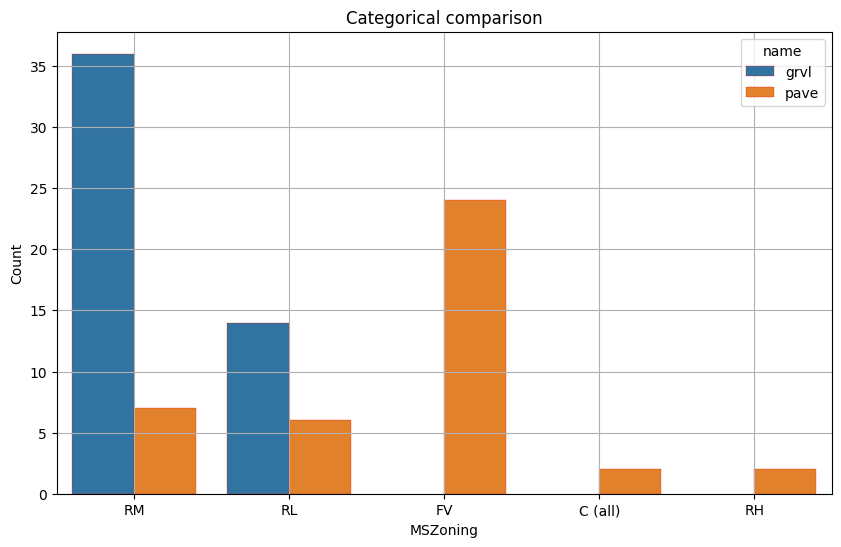

In [354]:
datasets_zone = {
    "grvl": data_grvl['MSZoning'],
    "pave": data_pave['MSZoning']
}

feature_plots.BuildHist(datasets_zone).categorical_hist()

del datasets_zone

Мы можем **восстановить часть данных заполнив Alley** со значением pave по MSZoning со значениями FV и RH.

In [355]:
data_test_alley.loc[data_test_alley['MSZoning'] == 'FV', 'Alley'] = 'Pave'
data_test_alley.loc[data_test_alley['MSZoning'] == 'RH', 'Alley'] = 'Pave'
data_test_alley.loc[data_test_alley['MSZoning'] == 'C (all)', 'Alley'] = 'Pave'

In [356]:
four_step_mae = data_tools.PipelineManager(data_test_alley, baseline_model).get_baseline()
print(f'МАЕ Difference: {round((four_step_mae - three_step_mae), 2)}')

МАЕ Difference: 86.65


Рассмотрим возможность **восстановления данных по году постройки**.

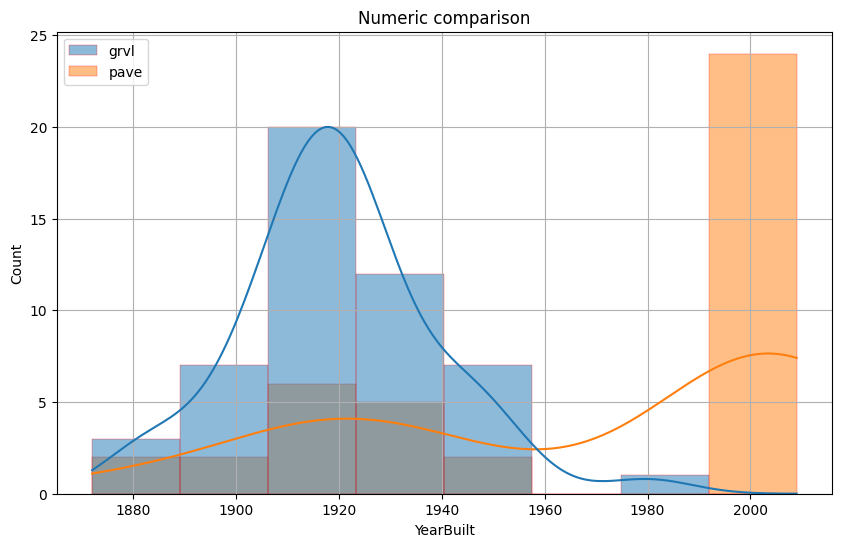

In [357]:
datasets_year = {
    "grvl": data_grvl['YearBuilt'],
    "pave": data_pave['YearBuilt']
}

feature_plots.BuildHist(datasets_year).numeric_plot()

del datasets_year

Заметим, что после 1990 года, с большой уверенностью, можем восстановить Alley со значением Pave.

In [358]:
data_test_alley.loc[(data_test_alley['YearBuilt'] >= 1990) & (data_test_alley['Alley'].isna()), 'Alley'] = 'Pave'

In [359]:
five_step_mae = data_tools.PipelineManager(data_test_alley, baseline_model).get_baseline()
print(f'МАЕ Difference: {round((five_step_mae - four_step_mae), 2)}')

МАЕ Difference: 0.0


Так же рассмотрим по году постройке гаража. 

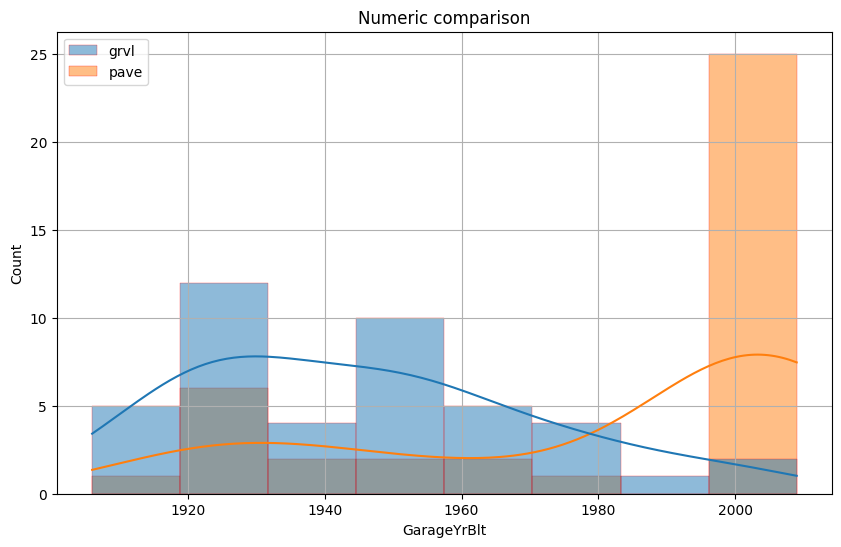

In [360]:
datasets_garage = {
    "grvl": data_grvl['GarageYrBlt'],
    "pave": data_pave['GarageYrBlt']
}

feature_plots.BuildHist(datasets_garage).numeric_plot()

del datasets_garage

Так же **восстановим данные по гаражу после 2000 года**.

In [361]:
data_test_alley.loc[(data_test_alley['GarageYrBlt'] >= 2000) & (data_test_alley['Alley'].isna()), 'Alley'] = 'Pave'

In [362]:
six_step_mae = data_tools.PipelineManager(data_test_alley, baseline_model).get_baseline()
print(f'МАЕ Difference: {round((six_step_mae - five_step_mae), 2)}')

МАЕ Difference: 0.0


Попробуем **восстановить данные по соседям**.

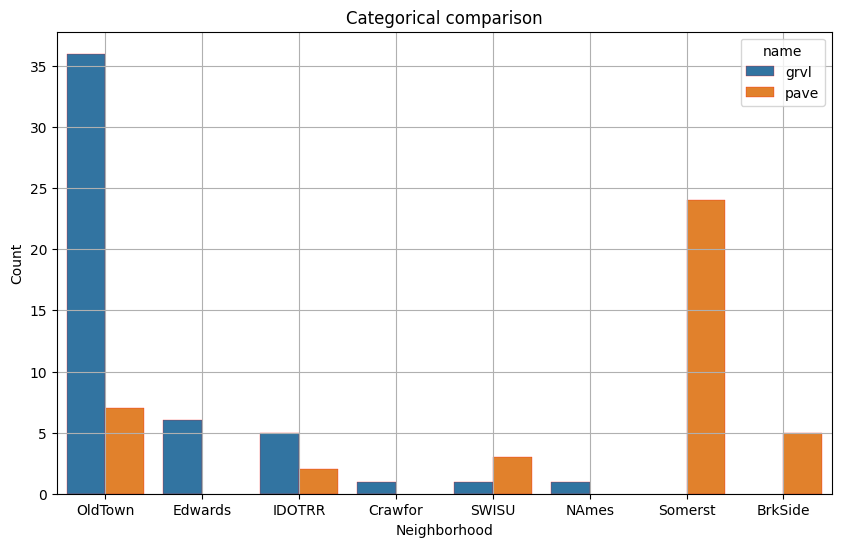

In [363]:
datasets_neighborhood = {
    "grvl": data_grvl['Neighborhood'],
    "pave": data_pave['Neighborhood']
}

feature_plots.BuildHist(datasets_neighborhood).categorical_hist()

del datasets_neighborhood

**Восстановим** данные там, где **однозначено определено значение по столбцу**.

In [364]:
data_test_alley.loc[(data_test_alley['Neighborhood'] == 'Crawfor') & (data_test_alley['Alley'].isna()), 'Alley'] = 'Grvl'
data_test_alley.loc[(data_test_alley['Neighborhood'] == 'Edwards') & (data_test_alley['Alley'].isna()), 'Alley'] = 'Grvl'
data_test_alley.loc[(data_test_alley['Neighborhood'] == 'NAmes') & (data_test_alley['Alley'].isna()), 'Alley'] = 'Grvl'
data_test_alley.loc[(data_test_alley['Neighborhood'] == 'Somerst') & (data_test_alley['Alley'].isna()), 'Alley'] = 'Pave'
data_test_alley.loc[(data_test_alley['Neighborhood'] == 'BrkSide') & (data_test_alley['Alley'].isna()), 'Alley'] = 'Pave'

In [365]:
seven_step_mae = data_tools.PipelineManager(data_test_alley, baseline_model).get_baseline()
print(f'МАЕ Difference: {round((seven_step_mae - six_step_mae), 2)}')

МАЕ Difference: -104.06


Суммарно не получится лучше, нежели заполнить эту фичу.

**Один из приёмов** по восстановлению данных **сработал**, но **выполним наилучшее действие**.

In [366]:
train, test = data_tools.Evaluate(train, test, 'Alley', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,17497.49
Drop,-34.92,17462.57
Fill,-53.00,17444.49
Mapping,115.50,17612.99
Bool,174.37,17671.86


Фича Alley заполнена меткой
Фича Alley заполнена меткой


`MasVnrType` - Тип облицовки каменной кладкой

In [367]:
train, test = data_tools.Evaluate(train, test, 'MasVnrType', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,17671.86
Drop,-94.47,17577.39
Fill,-197.71,17474.15
Mapping,-156.32,17515.54
Bool,-8.91,17662.95


Фича MasVnrType заполнена меткой
Фича MasVnrType заполнена меткой


**Немного потеряли в качестве** по этой фиче.

`Fence` - Забор

In [368]:
train['Fence'].value_counts()

Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: count, dtype: int64

MnPrv — среднее качество ограды.

GdPrv — хорошее качество ограды.

GdWo — хорошая ограда без покрытия (без покрытия или "без обработки").

MnWw — низкое качество ограды.

In [369]:
train, test = data_tools.Evaluate(train, test, 'Fence', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,17662.95
Drop,-177.02,17485.93
Fill,-51.70,17611.25
Mapping,-124.79,17538.16
Bool,26.22,17689.17


Удалена фича Fence
Удалена фича Fence


`FireplaceQu` - Качество камина

In [370]:
train['FireplaceQu'].value_counts()

FireplaceQu
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64

Gd — Good (хорошее качество камина).

TA — Typical Average (среднее стандартное качество камина).

Fa — Fair (небольшое ухудшение, камин в среднем состоянии).

Po — Poor (плохое качество камина).

Ex — Excellent (отличное качество камина).

In [371]:
_ = data_tools.Evaluate(train, test, 'FireplaceQu', baseline_model).info()
del _

,Difference MAE,Final MAE
Baseline,0.00,17485.93
Drop,-12.24,17473.69
Fill,0.70,17486.63
Mapping,32.19,17518.12
Bool,8.61,17494.54


Удалена фича FireplaceQu
Удалена фича FireplaceQu


Скорее всего пропуски в этих данных **означает отсутствие камина.**

In [372]:
print(f'Среднее количество каминов: {train['Fireplaces'][train['FireplaceQu'].isna()].mean()}')

Среднее количество каминов: 0.0


**Гипотеза подтвердилась**, поэтому мэппинг как раз поможет **заполнив фичу меткой NoFireplaceQu** и затем преобразуя в хэш-таблицу.

In [373]:
train, test = data_tools.Evaluate(train, test, 'FireplaceQu', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,17485.93
Drop,-12.24,17473.69
Fill,0.70,17486.63
Mapping,32.19,17518.12
Bool,8.61,17494.54


Удалена фича FireplaceQu
Удалена фича FireplaceQu


`Electrical`

In [374]:
print(f'Количество пропущенных данных: {train['Electrical'].isna().sum()}')

Количество пропущенных данных: 1


В этой фиче **пропущена одна строка, поэтому удалим ее**.

In [375]:
train = train.dropna(subset=['Electrical'])

**Итоговая метрика** после предобработки **категориальных** фичей.

In [376]:
categorical_mae = data_tools.PipelineManager(train, baseline_model).get_baseline()
print(f'МАЕ Forest: {categorical_mae}')
print(f'Разница MAE после преобработки: {round((categorical_mae - baseline_mae['MAE']),2)}')

МАЕ Forest: 16582.01
Разница MAE после преобработки: -1004.44


После длительной преобработки категориальных фичей **получили более лучшее значение МАЕ**.

##### 4.2. Количественные переменные c пропусками

`LotFrontage` - Линейные футы улицы, прилегающей к участку

**Посмотрим распредение** LotFrontage.

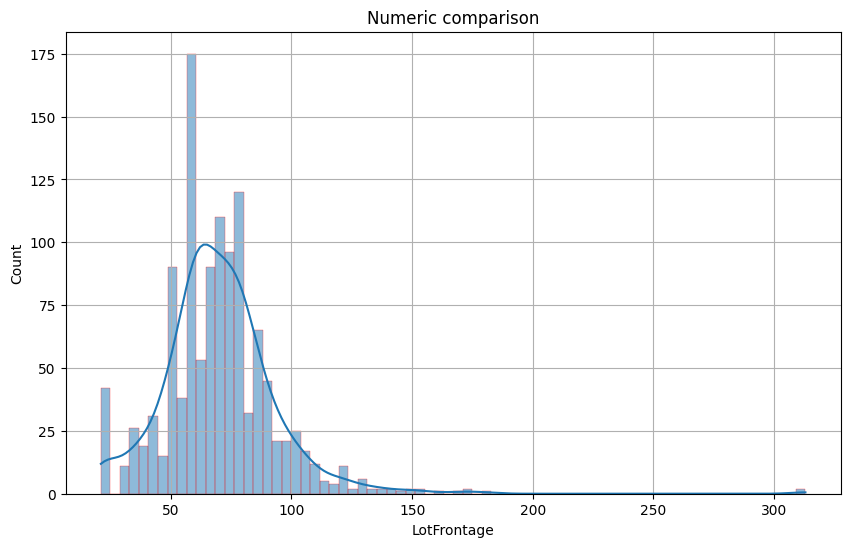

In [377]:
feature_plots.BuildHist(train['LotFrontage']).numeric_plot()

Так же **посмотрим на выбросы**.

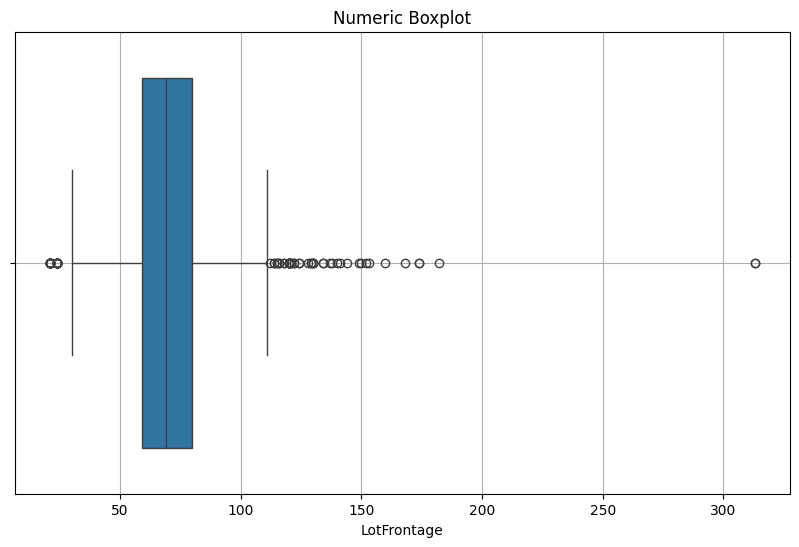

In [378]:
feature_plots.BuildHist(train['LotFrontage']).numeric_boxplot()

Так как **датасет основан на данных США**, то такие **большие значения прилегающей улицы явление нормальное**.

Осталось **исследовать пропущенные данные**.

In [379]:
print(f'Количество пропущенных данных: {train['LotFrontage'].isna().sum()}')

Количество пропущенных данных: 259


Проверим разные действия над этой фичей.

In [380]:
train, test = data_tools.Evaluate(train, test, 'LotFrontage', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,16582.01
Drop,-416.68,16165.33
Median,-130.10,16451.91
Mean,-40.68,16541.33
Mode,-26.16,16555.85


Удалена фича LotFrontage
Удалена фича LotFrontage


Такой **большой прирост по МАЕ после удаления** этой фичи говорит о том, что она **является не нужной**.

`MasVnrArea` - Площадь облицовки каменной кладкой в ​​квадратных футах  

**Посмотрим распределение** MasVnrArea.

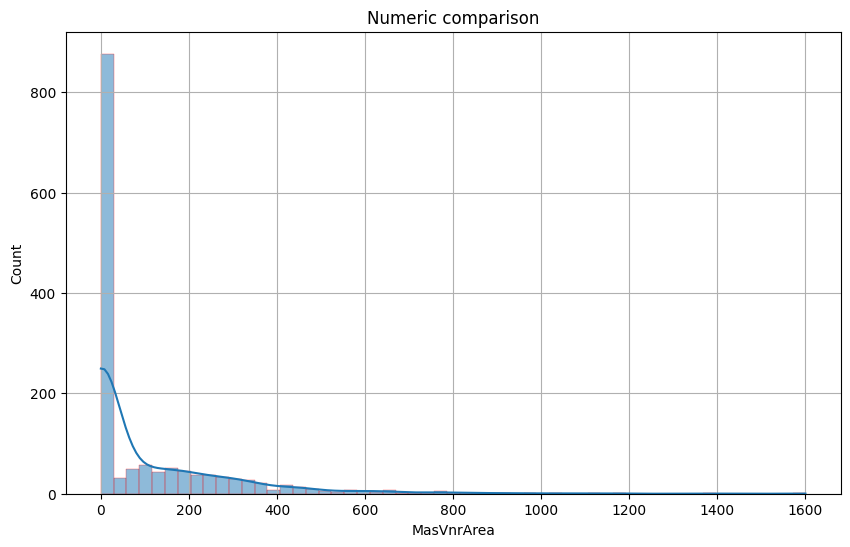

In [381]:
feature_plots.BuildHist(train['MasVnrArea']).numeric_plot()

**Посмотрим выбросы** MasVnrArea

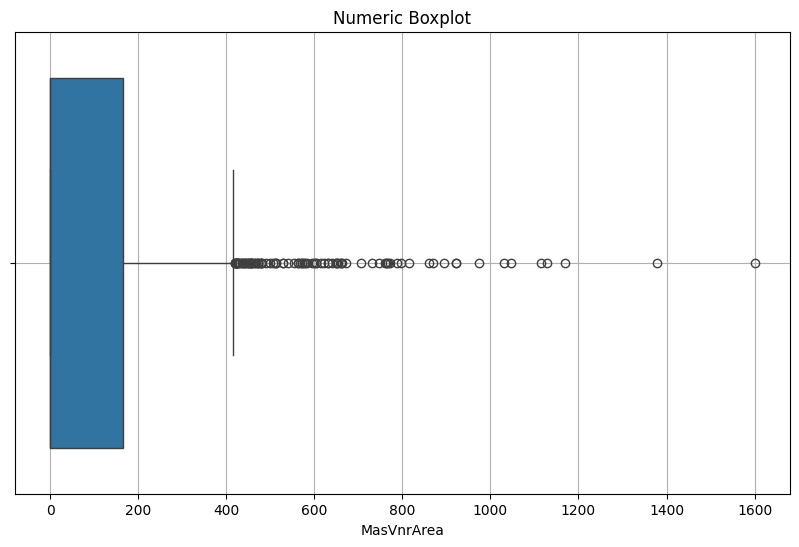

In [382]:
feature_plots.BuildHist(train['MasVnrArea']).numeric_boxplot()

Посмотрим параметры здания у которых MasVnrArea более 1000.

In [383]:
train.loc[train['MasVnrArea'] > 1000, ['MasVnrArea', 'LotArea', 'YearBuilt', 'SalePrice']]

,MasVnrArea,LotArea,YearBuilt,SalePrice
58,1031.0,13682,2006,438780
70,1115.0,13651,1973,244000
115,1129.0,3230,1999,176000
297,1600.0,7399,1997,239000
691,1170.0,21535,1994,755000
808,1047.0,13400,1966,159950
1169,1378.0,35760,1995,625000


Скорее всего **данные с индексами 115 и 297 являются выбросами**.

In [384]:
before_drop_mae = data_tools.PipelineManager(train, baseline_model).get_baseline()
train = train.drop(index=[115, 297])
eight_step_mae = data_tools.PipelineManager(train, baseline_model).get_baseline()
print(f'МАЕ Difference: {round((eight_step_mae - before_drop_mae), 2)}')

МАЕ Difference: -167.72


**(!) Улучшение на 167 долларов (По МАЕ) после удаление двух строк**.

Теперь примененим стандартные действия над фичей.

In [385]:
train, _ = data_tools.Evaluate(train, test, 'MasVnrArea', baseline_model).info()

,Difference MAE,Final MAE
Baseline,0.00,15997.61
Drop,271.41,16269.02
Median,-78.13,15919.48
Mean,-2.94,15994.67
Mode,-78.13,15919.48


Фича заполнена медианой MasVnrArea
Фича заполнена медианой MasVnrArea


In [386]:
print(f'Количество пропущенных данных: {train['MasVnrArea'].isna().sum()}')

Количество пропущенных данных: 0


`GarageYrBlt` - Год постройки гаража

In [387]:
missing_year = train.loc[train['GarageYrBlt'].isna(), ['GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt']]
missing_year.head(5)

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageCond,GarageYrBlt
39,0,0,No garage,No garage,No garage,No garage,NaN
48,0,0,No garage,No garage,No garage,No garage,NaN
78,0,0,No garage,No garage,No garage,No garage,NaN
88,0,0,No garage,No garage,No garage,No garage,NaN
89,0,0,No garage,No garage,No garage,No garage,NaN


In [388]:
print(f'Среднее значение GarageArea: {missing_year['GarageArea'].mean()}')
print(f'Среднее значение GarageCars: {missing_year['GarageCars'].mean()}')

Среднее значение GarageArea: 0.0
Среднее значение GarageCars: 0.0


По этим строкам видно почему **данные по году постройки гаража пропущены - гараж вовсе отсутствует**.

In [389]:
train, _ = data_tools.Evaluate(train, test, 'GarageYrBlt', baseline_model).info()


,Difference MAE,Final MAE
Baseline,0.00,15919.48
Drop,110.35,16029.83
Median,62.24,15981.72
Mean,-10.03,15909.45
Mode,125.44,16044.92


Фича заполнена средним GarageYrBlt
Фича заполнена средним GarageYrBlt


**Итоговая метрика** после предобработки **количественных** фичей.

In [390]:
numeric_mae = data_tools.PipelineManager(train, baseline_model).get_baseline()
print(f'МАЕ Forest: {categorical_mae}')
print(f'Разница MAE после преобработки: {round((numeric_mae - categorical_mae),2)}')

МАЕ Forest: 16582.01
Разница MAE после преобработки: -672.56


##### 4.3. Проверка на мультиколлениарность

**Важной частью предобработки** является проверка на мультиколлениарность. Не избавившись от них модель может хуже улавливать связи.

In [391]:
scaler = StandardScaler()

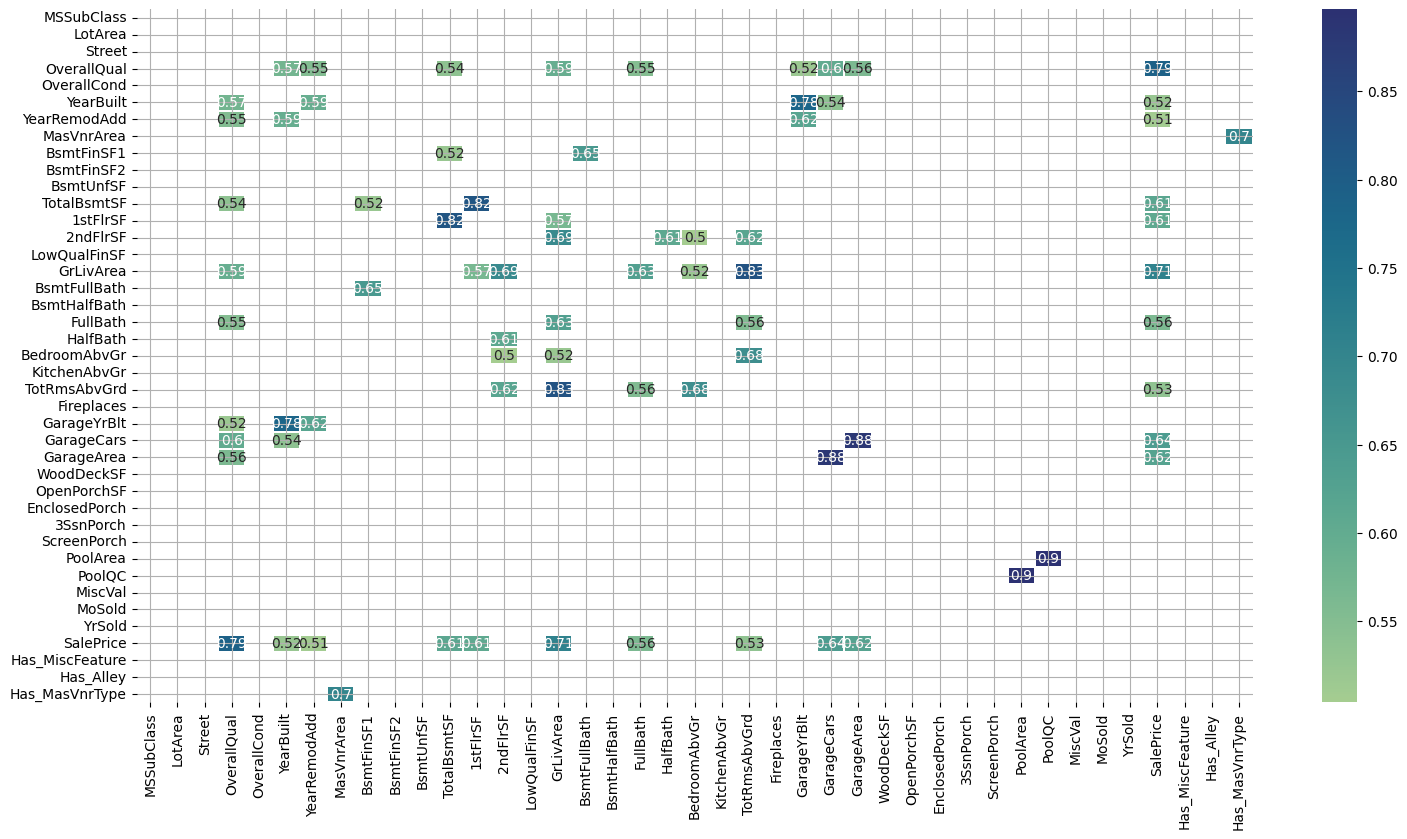

In [392]:
matrix, fig = data_tools.DataPreprocessor(train).check_multicollinearity(scaler, threshold=0.5)

**Сильно коррелирующие столбцы**:

 - OverallQual и SalePrice - Чем выше качество отделки, тем выше стоимость жилья. 

 - 1stFlrSF и TotalBsmtSF - Чем больше кв. футы первого этажа, тем выше общая площадь подвала. Это утверждение логично.

 - TotRmsAbvGrd и GrLivArea - Чем выше общее количество комнат, тем выше жилая площадь над уровнем земли.

 - GarageArea и GarageCars - Чем выше общая площадь гаража, тем выше вместительность для автомобилей.

Проверим что будет, **если избавимся от этих строк**.

In [393]:
drop_columns = ['OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'GarageCars']
df = train.copy()
data_tools.Evaluate(df, test=None, columns=drop_columns, model=baseline_model).evaluate_feature()

,Difference MAE
OverallQual,1348.54
1stFlrSF,1060.76
TotRmsAbvGrd,1059.20
GarageCars,1079.55


Несмотря на то, что столбцы сильно коррелируют, **обычное удаление сильно ухудшает модель**. Скорее всего другие **переменные влияют на коррелирующие фичи**, поэтому можно предположить, что **взаимносвязь нелинейная**. 

**Пример:** Рост и вес человека обычно всегда с положительной корреляцией причем сильной. Но важно учесть возраст человека, т.к. до 20 лет эта связь гораздо сильнее, т.к. он растет, нежели потом. 

##### 4.4. Оценка важности признаков

**Произведем отбор признаков** через RandomForest.

In [394]:
search_model = RandomForestRegressor(n_jobs=-1)

In [395]:
search_params = {
    'reg__n_estimators' : randint(20, 700),
    'reg__max_depth' : randint(3, 20),
    'reg__min_samples_split': randint(2, 10),
    'reg__min_samples_leaf': randint(1, 4)
}

In [396]:
search = data_tools.PipelineManager(train, search_model).train_model(search_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры модели: {'reg__max_depth': 14, 'reg__min_samples_leaf': 1, 'reg__min_samples_split': 3, 'reg__n_estimators': 582}
MAE модели: 16068.65


**Оценим важность признаков**.

In [397]:
importance = data_tools.PipelineManager(train, model=search).imporance_columns()

display(importance.head(10))

,Importance
OverallQual,0.32
GrLivArea,0.14
TotalBsmtSF,0.03
BsmtFinSF1,0.01
YearBuilt,0.01
GarageCars,0.01
OverallCond,0.01
1stFlrSF,0.01
LotArea,0.01
GarageArea,0.01


C:\Users\46120\AppData\Local\Temp\ipykernel_10900\2125045740.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp,


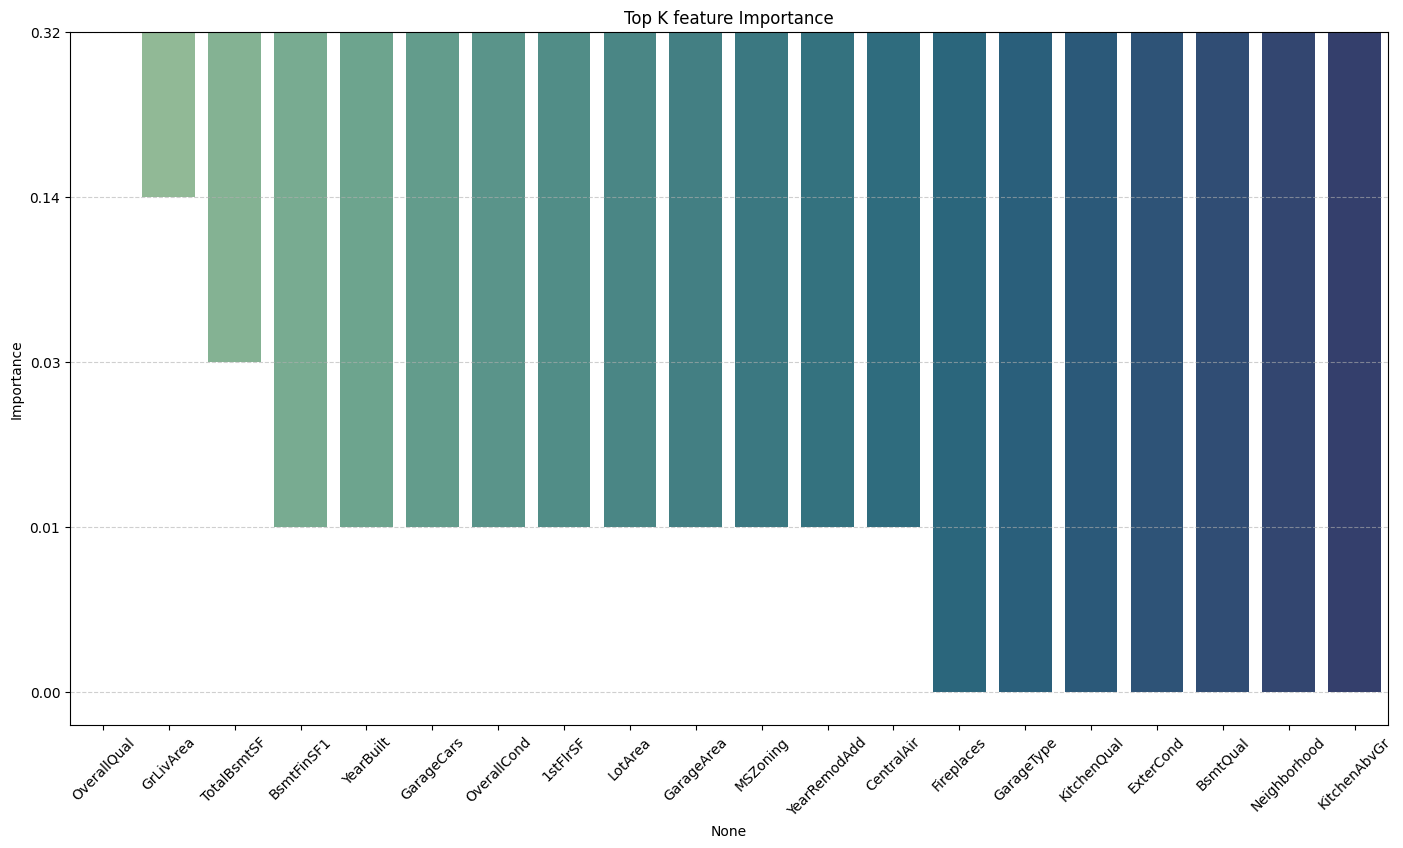

In [398]:
imp = importance.head(20)

plt.figure(figsize=(17, 9))

sns.barplot(data=imp,
            x=imp.index,
            y='Importance',
            palette='crest');

plt.xticks(rotation=45)
plt.title('Top K feature Importance')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show();

Случайный лес плохо подходит под эти данные, **лучше всего проверять линейной регрессии**, т.к. она прекрасно работает с большим количеством фичей, и возможностью использовать не только евклидово расстояние, но и манхеттенское, которое в свою очередь **зануляет ненужные признаки**. Проверим отобранные признаки через Lasso.

In [399]:
lasso_params = data_tools.load_json('./model/lasso_params.json')

In [400]:
lasso_model = Lasso()

In [401]:
feature_lasso = data_tools.PipelineManager(train, lasso_model).train_model(lasso_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Лучшие параметры модели: {'reg__alpha': 0.01}
MAE модели: 17390.2


c:\Users\46120\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [402]:
preprocessor = feature_lasso.named_steps['prep'] 
numeric = preprocessor.transformers_[0][2] 
lasso_model = feature_lasso.named_steps['reg']
coefficients = lasso_model.coef_
coef_data = pd.DataFrame({
    'Feature': numeric,
    'Coefficient': coefficients[:len(numeric)]
}).sort_values(by='Coefficient', ascending=False)

**(!) Важный момент**, т.к. применяется OneHotEncoder, то сейчас параметров невероятно много. Столбцы с категориальными фичами разделились, поэтому проверяем важность признаков только на количественных фичах.

In [403]:
display(coef_data)

,Feature,Coefficient
3,OverallQual,0.124549
15,GrLivArea,0.094834
5,YearBuilt,0.066464
25,GarageCars,0.066070
4,OverallCond,0.036377
23,Fireplaces,0.032138
6,YearRemodAdd,0.027688
16,BsmtFullBath,0.025202
11,TotalBsmtSF,0.018133
22,TotRmsAbvGrd,0.017885


In [404]:
unimportance_columns = list(coef_data[coef_data['Coefficient'] <= 0]['Feature'])

In [405]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPor

In [406]:
before_drop = data_tools.PipelineManager(train, baseline_model).get_baseline()
train = train.drop(columns=unimportance_columns)
after_drop = data_tools.PipelineManager(train, baseline_model).get_baseline()
print(f'МАЕ Difference: {round((after_drop - before_drop), 2)}')

МАЕ Difference: -208.21


In [407]:
test = test.drop(columns=unimportance_columns)

Сохраним данные для следующего блока.

In [408]:
train.to_csv('./data/train_pred.csv')
test.to_csv('./data/test_pred.csv')

#### Вывод

In [409]:
print(f'Итоговая разница МАЕ: {round((after_drop - baseline_mae['MAE']), 2)}')

Итоговая разница МАЕ: -1885.21


На этапе предобработки выполнены все необходимые шаги для подготовки данных к обучению модели.
Основные действия включали:

* удаление неинформативных и дублирующих признаков (Id, Utilities, Street и др.);

* обработку пропусков с использованием подходящих стратегий (медиана, мода, специальные категории “No ...”);

* кодирование категориальных признаков с помощью OneHotEncoder и/или числового отображения (mapping);

* масштабирование числовых признаков с помощью StandardScaler;

* проверку и устранение мультиколлинеарности между признаками.

После выполнения этих шагов датасет:

* очищен от пропусков и некорректных значений;

* приведён к единому формату, совместимому с моделями машинного обучения;

* готов для обучения и дальнейшего подбора гиперпараметров.

Итог:
Получен финальный обучающий набор данных с оптимизированным числом признаков, корректными типами и стабильной структурой.
Теперь можно переходить к следующему этапу — обучению и оценке моделей.